In [1]:
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from spe.estimators import kfoldcv, kmeanscv, cp_general, simple_train_test_split
from spe.relaxed_lasso import RelaxedLasso

In [2]:
np.random.seed(1)

In [3]:
nv_df = pd.read_csv('../datasets/NV_SMU_wells_shared_kevin_prep_Nov6.csv')
# nm_df = pd.read_csv('../datasets/NM_SMU_wells_shared_kevin_prep_Nov6.csv')

NameError: name 'pd' is not defined

In [ ]:
nv_df

,OBJECTID,Temp_C,Depth_m,GeothermGrad,X_83UTM11_round,Y_83UTM11_round,row,column,id_rc,X_83UTM11,...,Hillshade-100m,DEM-30m,Fairway,Domain,T37,QuaternaryFaultDistance,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate
0,1,115.56,30.5,3645.0,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
1,2,115.56,30.5,3645.0,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
2,119,63.79,64.0,984.4,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
3,120,63.79,64.0,984.4,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
4,123,67.09,54.9,950.9,296000.0,4475000.0,864.0,37.0,R865C38,295577.690182,...,181,1233,43.512299,3,12,-0.866128,0.730942,0.913039,-0.103709,0.834592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,4818,15.80,108.8,24.8,293000.0,4497000.0,952.0,25.0,R953C26,292577.690182,...,179,1195,41.517601,0,12,2.386731,0.907021,0.641172,0.957744,0.713252
3322,4821,0.00,350.0,24.6,680000.0,4326000.0,268.0,1573.0,R269C1574,679577.690182,...,198,2654,38.367802,4,12,0.124746,-0.521456,-0.566835,-0.398600,-0.574790
3323,4822,0.00,350.0,24.6,680000.0,4326000.0,268.0,1573.0,R269C1574,679577.690182,...,198,2654,38.367802,4,12,0.124746,-0.521456,-0.566835,-0.398600,-0.574790
3324,4823,11.20,85.0,24.6,455000.0,4490000.0,924.0,673.0,R925C674,454577.690182,...,191,1713,48.116501,2,12,-0.469778,2.381751,4.019012,0.525528,1.601224


In [ ]:
nv_df.columns

Index(['OBJECTID', 'Temp_C', 'Depth_m', 'GeothermGrad', 'X_83UTM11_round',
       'Y_83UTM11_round', 'row', 'column', 'id_rc', 'X_83UTM11', 'Y_83UTM11',
       'NullInfo', 'TrainCodeNeg', 'TrainCodePos', 'TrainCodePosT130',
       'PosSite130_Id', 'PosSite130_Distance', 'PosSite_Id',
       'PosSite_Distance', 'NegSite_Id', 'NegSite_Distance',
       'Local_polygon_Id', 'Local_polygon_overlap_Id', 'QuaternaryFaultTraces',
       'GeodeticStrainRate', 'QuaternarySlipRate', 'FaultRecency',
       'FaultSlipDilationTendency2', 'Earthquakes', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GravityDensity', 'MagneticDensity',
       'Heatflow', 'GeochemistryTemperature2', 'Tufa_Distance',
       'Travertine_Distance', 'Silica_Distance', 'TufaOrTravertine_Distance',
       'FavorableStructuralSettings_Distance', 'Local-StructuralSetting_Error',
       'Local-QuaternaryFaultRecency_Error',
       'Local-QuaternaryFaultSlipDilation_Error',
       'Local-QuaternaryFaultSlipRate_Error

In [ ]:
feature_cols = [
    'Depth_m',
    'GeothermGrad',
    'QuaternaryFaultTraces',
    'GeodeticStrainRate',
    'QuaternarySlipRate',
    'FaultRecency',
    'FaultSlipDilationTendency2',
    'Earthquakes',
    'HorizGravityGradient2',
    'HorizMagneticGradient2',
    'GravityDensity',
    'MagneticDensity',
    'Heatflow',
    'HorizGravityGradient2',
    'Tufa_Distance',
    'Travertine_Distance',
    'Silica_Distance',
    'FavorableStructuralSettings_Distance',
    'QuaternaryFaultDistance',
]
y_cols = 'Temp_C'
loc_cols = ['X_83UTM11_round', 'Y_83UTM11_round']

In [ ]:
non_nan_nv_df = nv_df[feature_cols+[y_cols]+loc_cols].dropna(axis=0)

In [ ]:
non_nan_nv_df.isna().mean()

Depth_m                                 0.0
GeothermGrad                            0.0
QuaternaryFaultTraces                   0.0
GeodeticStrainRate                      0.0
QuaternarySlipRate                      0.0
FaultRecency                            0.0
FaultSlipDilationTendency2              0.0
Earthquakes                             0.0
HorizGravityGradient2                   0.0
HorizMagneticGradient2                  0.0
GravityDensity                          0.0
MagneticDensity                         0.0
Heatflow                                0.0
HorizGravityGradient2                   0.0
Tufa_Distance                           0.0
Travertine_Distance                     0.0
Silica_Distance                         0.0
FavorableStructuralSettings_Distance    0.0
QuaternaryFaultDistance                 0.0
Temp_C                                  0.0
X_83UTM11_round                         0.0
Y_83UTM11_round                         0.0
dtype: float64

In [ ]:
locs = non_nan_nv_df[loc_cols]
y = non_nan_nv_df[y_cols]
X = non_nan_nv_df[feature_cols]

In [ ]:
X.shape

(2558, 21)

In [ ]:
X

,Depth_m,GeothermGrad,QuaternaryFaultTraces,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,HorizGravityGradient2,HorizGravityGradient2,...,GravityDensity,MagneticDensity,Heatflow,HorizGravityGradient2,HorizGravityGradient2,Tufa_Distance,Travertine_Distance,Silica_Distance,FavorableStructuralSettings_Distance,QuaternaryFaultDistance
0,30.5,3645.0,0,1.405800,-2.67835,1.64040,0.848943,2.15987,0.005064,0.005064,...,2,8,87.680901,0.005064,0.005064,28851.413871,48392.998068,714.858718,3740.632974,-0.866128
1,30.5,3645.0,0,1.405800,-2.67835,1.64040,0.848943,2.15987,0.005064,0.005064,...,2,8,87.680901,0.005064,0.005064,28851.413871,48392.998068,714.858718,3740.632974,-0.866128
2,64.0,984.4,0,1.405800,-2.67835,1.64040,0.848943,2.15987,0.005064,0.005064,...,2,8,87.680901,0.005064,0.005064,28851.413871,48392.998068,714.858718,3740.632974,-0.866128
3,64.0,984.4,0,1.405800,-2.67835,1.64040,0.848943,2.15987,0.005064,0.005064,...,2,8,87.680901,0.005064,0.005064,28851.413871,48392.998068,714.858718,3740.632974,-0.866128
4,54.9,950.9,0,1.405800,-2.67835,1.64040,0.848943,2.15987,0.005064,0.005064,...,2,8,87.680901,0.005064,0.005064,28851.413871,48392.998068,714.858718,3740.632974,-0.866128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,108.8,24.8,0,1.343000,-2.45373,1.57206,0.860139,2.24428,0.004033,0.004033,...,6,2,74.396004,0.004033,0.004033,51020.679897,34537.742087,8914.088404,5056.693849,2.386731
3322,350.0,24.6,0,0.462398,-2.72502,2.45524,0.783172,1.42325,0.000988,0.000988,...,23,8,78.786400,0.000988,0.000988,322268.860515,68016.522897,172065.856774,10037.757911,0.124746
3323,350.0,24.6,0,0.462398,-2.72502,2.45524,0.783172,1.42325,0.000988,0.000988,...,23,8,78.786400,0.000988,0.000988,322268.860515,68016.522897,172065.856774,10037.757911,0.124746
3324,85.0,24.6,0,1.374350,-1.84191,1.85678,0.776615,1.64836,0.001607,0.001607,...,29,20,74.607201,0.001607,0.001607,85962.466756,22944.375680,10896.855100,1522.267172,-0.469778


In [ ]:
px.scatter(locs, x='X_83UTM11_round', y='Y_83UTM11_round')

In [ ]:
y.describe()

count    2558.000000
mean       31.854096
std        35.015236
min         0.000000
25%        16.535000
50%        22.720000
75%        33.000000
max       283.700000
Name: Temp_C, dtype: float64

In [ ]:
(y == 0).sum(), (y == 0).mean()

(367, 0.1434714620797498)

<Axes: >

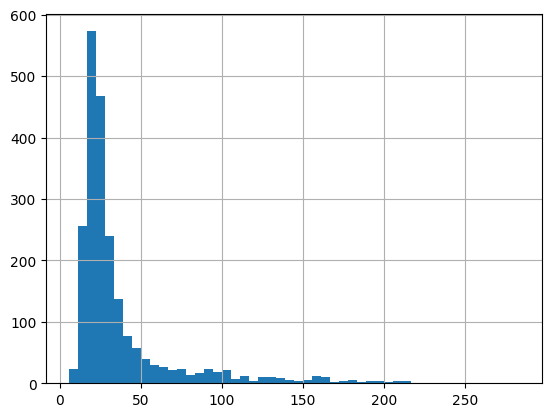

In [ ]:
y[y != 0].hist(bins=50)

<Axes: >

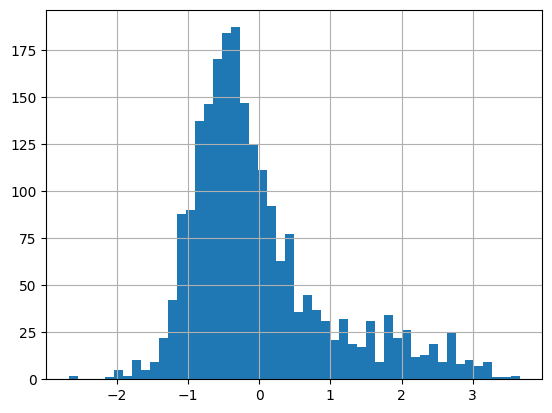

In [ ]:
((np.log(y[y != 0]) - np.log(y[y != 0]).mean()) / (np.log(y[y != 0]).std())).hist(bins=50)

# NOT normal, but shouldn't be because sampling is not random, this is not conditional on $X$.

In [ ]:
filtered_nv_df = non_nan_nv_df[y != 0]
filtered_nv_df = filtered_nv_df.drop_duplicates() ## found lots of duplicates (~40%)
filtered_nv_df = filtered_nv_df.drop_duplicates(subset=["X_83UTM11_round", "Y_83UTM11_round"]) ## even within this there are duplicated locations (~20%)

locs = filtered_nv_df[loc_cols]
y = filtered_nv_df[y_cols]
X = filtered_nv_df[feature_cols]

In [ ]:
X.shape, y.shape, locs.shape

((1009, 21), (1009,), (1009, 2))

In [ ]:
## GenCp parameters
niter = 10
alpha = .05
nboot = 100
k = 30

models = [
    XGBRegressor(
        max_depth=2, 
        n_estimators=100
    ), 
    XGBRegressor(
        max_depth=6, 
        n_estimators=100
    ), 
    RandomForestRegressor(
        max_depth=2, 
        max_features='sqrt',
        n_estimators=100
    ),
    RandomForestRegressor(
        max_depth=6, 
        max_features='sqrt',
        n_estimators=100
    ),
    ElasticNetCV()
]

## plot parameters
title = "General Model Comparisons"
est_names = ["XGB2", "XGB6", "RF2", "RF6", "ENetCV"]
# model_names = ["Lasso CV"]

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import skgstat as skg
from scipy.spatial import distance_matrix

# Estimate Covariance

In [ ]:
n = locs.shape[0]
est_sigma_model = RandomForestRegressor(
    max_depth=3, 
    max_features='sqrt'
)

if est_sigma_model is None:
    raise ValueError("Must provide est_simga_model")

# est_sigma_model.fit(X_tr, y_tr)
# resids =  y_tr - est_sigma_model.predict(X_tr)
est_sigma_model.fit(X, y)
resids =  y - est_sigma_model.predict(X)
full_distance = distance_matrix(locs, locs)

# V = skg.Variogram(locs_tr, resids, model='matern')
V_nugget = skg.Variogram(locs, resids, model='matern', maxlag='median', use_nugget=True)

fitted_vm_nugget = V_nugget.fitted_model
semivar_nugget = fitted_vm_nugget(full_distance.flatten()).reshape((n,n))

V_nonugget = skg.Variogram(locs, resids, model='matern', maxlag='median', use_nugget=False)

fitted_vm_nonugget = V_nonugget.fitted_model
semivar_nonugget = fitted_vm_nonugget(full_distance.flatten()).reshape((n,n))

In [ ]:
K0 = V_nugget.parameters[1] ## partial sill
N0 = V_nugget.parameters[-1] ## nugget
est_Cov_SSN = est_Sigma_S = (K0+N0)*np.ones_like(semivar_nugget) - semivar_nugget ## Cov(Y, Y^*)
est_Sigma_M = N0*np.eye(semivar_nugget.shape[0])
est_Chol_SSN = np.linalg.cholesky(est_Sigma_S + est_Sigma_M) ## Var(Y) = Var(Y^*)

In [ ]:
K0 = V_nonugget.parameters[1] ## partial sill
est_Sigma = (K0)*np.ones_like(semivar_nonugget) - semivar_nonugget ## Cov(Y, Y^*)
est_Chol_NSN = np.linalg.cholesky(est_Sigma) ## Var(Y) = Var(Y^*)

# In-sample

## Model Comparison

In [ ]:
errs_SSN = []
for model in models:
    err = []
    for i in tqdm(range(niter)):
        e = cp_general(
            model=model,
            X=X, 
            y=y,
            tr_idx=np.ones_like(y),
            use_trace_corr=False,
            Chol_y=est_Chol_SSN,
            Cov_y_ystar=est_Cov_SSN,
            nboot=nboot,
            alpha=alpha,
        )
        err.append(e)
    errs_SSN.append(err)

100%|██████████| 10/10 [00:41<00:00,  4.11s/it]


In [ ]:
fig_SSN = make_subplots(
    rows=1, cols=1
)

df_SSN = pd.DataFrame({est_names[i]: errs_SSN[i] for i in np.arange(len(est_names))})

fig_SSN.add_trace(go.Bar(
    x = df_SSN.columns,
    y=df_SSN.mean(),
    marker_color=px.colors.qualitative.Plotly[0],
    text=np.around(df_SSN.mean(),3),
    textposition='outside',
    error_y=dict(
        type='data',
        color='black',
        array=df_SSN.std(),
    )
), row=1, col=1)

fig_SSN.update_yaxes(title_text="GenCp Estimated MSE", row=1, col=1)
fig_SSN.update_layout(title_text="Nevada Data: In-Sample Model Comparison", showlegend=False)
fig_SSN.show()

## Estimator Comparison

In [ ]:
# xgb = XGBRegressor(max_depth=3, n_estimators=10)
rf = RandomForestRegressor(
    max_depth=2,
    max_features='sqrt',
    n_estimators=100,
)
rl = RelaxedLasso(lambd=.5)


In [ ]:

res_gen = []
for i in tqdm(range(niter)):
    r = cp_general(
        model=rf,
        X=X, 
        y=y,
        tr_idx=np.ones_like(y),
        use_trace_corr=False,
        Chol_y=est_Chol_SSN,
        Cov_y_ystar=est_Cov_SSN,
        nboot=nboot,
        alpha=alpha,
    )
    res_gen.append(r)

100%|██████████| 10/10 [01:44<00:00, 10.50s/it]


In [ ]:
res_kfcv = []
for i in tqdm(range(niter)):
    r = kfoldcv(
        model=rf,
        X=X.values, 
        y=y.values,
        k=k,
    )
    res_kfcv.append(r)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/kevinfry/opt/anaconda3/envs/spe/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning:

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.

 10%|█         | 1/10 [00:02<00:26,  2.92s/it]/Users/kevinfry/opt/anaconda3/envs/spe/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning:

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.

 20%|██        | 2/10 [00:05<00:23,  2.92s/it]/Users/kevinfry/opt/anaconda3/envs/spe/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning:

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.

 30%|███       | 3/10 [00:08<00:20,  2.92s/it]/Users/kevinfry/opt/anaconda3/envs/spe/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning:

`fit_param

In [ ]:
res_spcv = []
for i in tqdm(range(niter)):
    r = kmeanscv(
        model=rf,
        X=X.values, 
        y=y.values,
        coord=locs.values,
        k=k,
    )
    res_spcv.append(r)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/kevinfry/opt/anaconda3/envs/spe/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning:

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.

 10%|█         | 1/10 [00:02<00:26,  2.98s/it]/Users/kevinfry/opt/anaconda3/envs/spe/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning:

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.

 20%|██        | 2/10 [00:05<00:23,  2.97s/it]/Users/kevinfry/opt/anaconda3/envs/spe/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning:

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.

 30%|███       | 3/10 [00:08<00:20,  2.97s/it]/Users/kevinfry/opt/anaconda3/envs/spe/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning:

`fit_param

In [ ]:
fig_cv = make_subplots(
    rows=1, cols=1
)

df = pd.DataFrame({
    'GenCp': errs_SSN[2],#res_gen,
    'KFCV': res_kfcv,
    'SPCV': res_spcv,
})

fig_cv.add_trace(go.Bar(
    x=df.columns,
    y=df.mean(),
    marker_color=px.colors.qualitative.Plotly,
    text=np.around(df.mean(),1),
    textposition='outside',
    error_y=dict(
            type='data',
            color='black',
            array=df.std(),
        )
), row=1, col=1)

fig_cv.update_yaxes(title_text="Estimated MSE", row=1, col=1)
fig_cv.update_xaxes(title_text="Method", row=1, col=1)
fig_cv.update_layout(title="Nevada Data: RF Estimated MSE", showlegend=False)
fig_cv.show()

# Spatial out-sample

In [ ]:
tr_frac = .8
tr_idx = np.concatenate((np.ones(int(tr_frac*n)), np.zeros(n - int(tr_frac*n)))).astype(bool)
np.random.shuffle(tr_idx)

## Model Comparison

In [ ]:
errs_SSN_spat = []
for model in models:
    err = []
    for i in tqdm(range(niter)):
        e = cp_general(
            model=model,
            X=X, 
            y=y,
            tr_idx=tr_idx,
            use_trace_corr=False,
            Chol_y=est_Chol_SSN,
            Cov_y_ystar=est_Cov_SSN,
            nboot=nboot,
            alpha=alpha,
        )
        err.append(e)
    errs_SSN_spat.append(err)

100%|██████████| 10/10 [00:39<00:00,  3.98s/it]


In [ ]:
fig_SSN_spat = make_subplots(
    rows=1, cols=1
)

df_SSN_spat = pd.DataFrame({est_names[i]: errs_SSN_spat[i] for i in np.arange(len(est_names))})

fig_SSN_spat.add_trace(go.Bar(
    x = df_SSN_spat.columns,
    y=df_SSN_spat.mean(),
    marker_color=px.colors.qualitative.Plotly,
    text=np.around(df_SSN_spat.mean(),3),
    textposition='outside',
    error_y=dict(
        type='data',
        color='black',
        array=df_SSN_spat.std(),
    )
), row=1, col=1)

fig_SSN_spat.update_yaxes(title_text="GenCp Estimated MSE", row=1, col=1)
fig_SSN_spat.update_layout(title_text="Nevada Data: Train/Test Split Model Comparison", showlegend=False)
fig_SSN_spat.show()

## Estimator Comparison

In [ ]:
# xgb = XGBRegressor(max_depth=3, n_estimators=10)
rf = RandomForestRegressor(
    max_depth=3,
    max_features='sqrt',
    n_estimators=100,
)

In [ ]:

res_gen_spat = []
for i in tqdm(range(2*niter)):
    r = cp_general(
        model=rf,
        X=X, 
        y=y,
        tr_idx=tr_idx,
        use_trace_corr=False,
        Chol_y=est_Chol_SSN,
        Cov_y_ystar=est_Cov_SSN,
        nboot=nboot,
        alpha=alpha,
    )
    res_gen_spat.append(r)

100%|██████████| 20/20 [03:18<00:00,  9.94s/it]


In [ ]:
res_kfcv_spat = []
for i in tqdm(range(10*niter)):
    r = simple_train_test_split(
        model=rf,
        X=X.values, 
        y=y.values,
        tr_idx=tr_idx,
    )
    res_kfcv_spat.append(r)

100%|██████████| 100/100 [00:09<00:00, 10.81it/s]


In [ ]:
fig_spat = make_subplots(
    rows=1, cols=1
)

df_spat = pd.DataFrame({
    'GenCp': res_gen_spat,
    'TrTs': res_kfcv_spat[:20],
})

fig_spat.add_trace(go.Bar(
    x=df_spat.columns,
    y=df_spat.mean(),
    marker_color=px.colors.qualitative.Plotly,
    text=np.around(df_spat.mean(),1),
    textposition='outside',
    error_y=dict(
            type='data',
            color='black',
            array=df_spat.std(),
        )
), row=1, col=1)

fig_spat.update_yaxes(title_text="Estimated MSE", row=1, col=1)
fig_spat.update_xaxes(title_text="Method", row=1, col=1)
fig_spat.update_layout(title="Nevada Data: Train/Test Split RF Estimated MSE", showlegend=False)
fig_spat.show()